In [1]:
# Load stored variables
%store -r sales_df

## Can we predict whether the opportunities in the engaged stage will be won?

#### The number of features is less than the number of training samples, and we have a mix of categorical and numeric features. We can use XGBoost to predict the close stage for prospecting and engaged deals.

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Prepare the dataset
df = sales_df[~sales_df['main_stage'].isin(['Prospecting', 'Engaging'])].copy()

# Encode categorical variables (excluding opportunity_id)
categorical_columns = ['sales_agent', 'product', 'sector', 'account']
label_encoders = {}

# Handle categorical encoding
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for later use

# Fill missing values
df = df.infer_objects(copy=False)

# Define features and target
X = df[['sales_agent', 'product', 'sales_price', 'sector', 'account', 'revenue', 'employees']]
y = df['deal_stage'].map({'Won': 1, 'Lost': 0})

# Separate the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Get the list of unique sales agents in the training set
known_agents = X_train['sales_agent'].unique()

# Load prospecting/engaging data
prospecting_data = sales_df[sales_df['main_stage'].isin(['Prospecting', 'Engaging'])].copy()

# Preserve the original opportunity_id
original_opportunity_id = prospecting_data['opportunity_id']

# Handle missing account values
prospecting_data['account'] = prospecting_data['account'].fillna('Unknown')

# Apply label encoders to prospecting_data
for col in categorical_columns:
    le = label_encoders[col]
    # Transform existing classes and set unknown classes to -1
    prospecting_data[col] = prospecting_data[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Filter out rows with unknown sales agents
prospecting_data = prospecting_data[prospecting_data['sales_agent'].isin(known_agents)]

# Prepare features for prediction
X_prospecting = prospecting_data[['sales_agent', 'product', 'sales_price', 'sector', 'account', 'revenue', 'employees']]

# Make predictions for prospecting data
prospecting_data['Predicted_Outcome'] = model.predict(X_prospecting)
prospecting_data['Win_Probability'] = model.predict_proba(X_prospecting)[:, 1]

# Add the original opportunity_id back to the output
prospecting_data['opportunity_id'] = original_opportunity_id

# Ensure opportunity_id is included in the output
output = prospecting_data[['opportunity_id', 'sales_agent', 'product', 'Predicted_Outcome', 'Win_Probability']]

# Display the results
print(output)


Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.05      0.09       507
           1       0.62      0.94      0.75       836

    accuracy                           0.61      1343
   macro avg       0.48      0.50      0.42      1343
weighted avg       0.52      0.61      0.50      1343

ROC-AUC Score: 0.50
     opportunity_id  sales_agent  product  Predicted_Outcome  Win_Probability
9          HAXMC4IX           12        5                  1         0.788492
25         UP409DSB           19        5                  1         0.527701
42         EG7OFLFR           14        1                  0         0.442620
44         OLVI7L8M            2        4                  1         0.769745
56         F5U1ACDD           14        2                  1         0.658952
...             ...          ...      ...                ...              ...
8795       9MIWFW5J           25        5                  1         0.546932
8796  

#### The ROC score is too low; it's comparable to guessing or flipping a coin. Let's try addressing the potential imbalance.

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.05      0.09       507
           1       0.62      0.94      0.75       836

    accuracy                           0.61      1343
   macro avg       0.48      0.50      0.42      1343
weighted avg       0.52      0.61      0.50      1343

ROC-AUC Score: 0.50
Feature Importance:


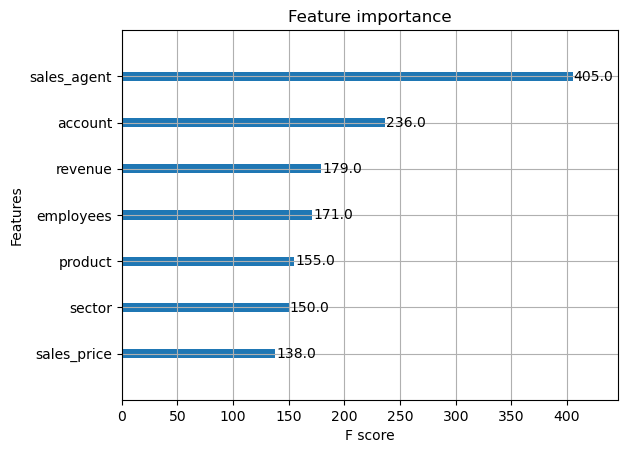

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Define features and target
X2 = df[['sales_agent', 'product', 'sales_price', 'sector', 'account', 'revenue', 'employees']]
y2 = df['deal_stage'].map({'Won': 1, 'Lost': 0})  # Convert target to binary

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Handle class imbalance by calculating scale_pos_weight
scale_pos_weight = len(y2_train[y2_train == 0]) / len(y2_train[y2_train == 1])

# Initialize the XGBClassifier with class weight handling
model2 = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
model2.fit(X_train, y_train)

# Make predictions on the test set
y2_pred = model.predict(X2_test)
y2_proba = model.predict_proba(X2_test)[:, 1]  # Probabilities for the positive class

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y2_test, y2_pred))

# Calculate and print the ROC-AUC score
roc_auc = roc_auc_score(y2_test, y2_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Feature importance analysis
print("Feature Importance:")
plot_importance(model2)
plt.show()

# Handle prospecting and engaging deals
prospecting_data2 = sales_df[sales_df['main_stage'].isin(['Prospecting', 'Engaging'])].copy()

# Encode prospecting data using the same encoders as training data
for col in categorical_columns:
    prospecting_data2[col] = prospecting_data2[col].map(
        lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
    )

# Define the same features for prospecting data
prospecting_data_X2 = prospecting_data2[['sales_agent', 'product', 'sales_price', 'sector', 'account', 'revenue', 'employees']]

# Predict outcomes and probabilities for prospecting data
prospecting_data2['Predicted_Outcome'] = model.predict(prospecting_data_X2)
prospecting_data2['Win_Probability'] = model.predict_proba(prospecting_data_X2)[:, 1]

#### ROC-AUC score didn't improve.  Let's add a new feature in our model: Win Rate

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


# Filter out 'Prospecting' and 'Engaging' from the main dataset for prediction
prospecting_data = sales_df[sales_df['main_stage'].isin(['Prospecting', 'Engaging'])].copy()
# Excluding opportunities without account
prospecting_data = prospecting_data[~prospecting_data['account'].isnull()]

# Encode categorical variables in both prospecting data and training data using label encoding
categorical_columns = ['sales_agent', 'product', 'sector', 'account']

label_encoders = {}  # To store encoders for later use
for col in categorical_columns:
    le = LabelEncoder()
    sales_df[col] = le.fit_transform(sales_df[col])  # Apply encoding to the full sales_df
    prospecting_data[col] = le.transform(prospecting_data[col])  # Apply encoding to prospecting_data
    label_encoders[col] = le  # Save encoder for later use

# Filter the main dataset to only include rows where 'deal_stage' is either 'Won' or 'Lost'
valid_deal_stages = ['Won', 'Lost']
sales_data_valid = sales_df[sales_df['deal_stage'].isin(valid_deal_stages)].copy()

# Group by sales_agent, product, account, sector and deal_stage to calculate 'Won' and 'Lost' counts
won_lost_counts = sales_data_valid.groupby(
    ['sales_agent', 'product', 'account', 'sector', 'deal_stage']
).size().unstack(fill_value=0)

# Calculate Won/Lost ratio: Won / Lost (add 1 to avoid division by zero)
won_lost_counts['Won_Lost_Ratio'] = won_lost_counts['Won'] / (won_lost_counts['Lost'] + 1)

# Calculate Win rate: Won / (Won + Lost)
won_lost_counts['Win_Rate'] = won_lost_counts['Won'] / (won_lost_counts['Won'] + won_lost_counts['Lost'])

# Merge these calculated features back into the main sales data
sales_data_valid = sales_data_valid.merge(
    won_lost_counts[['Won_Lost_Ratio', 'Win_Rate']],
    on=['sales_agent', 'product', 'account', 'sector'],
    how='left'
)

# Prepare the features for training the model
X = sales_data_valid[['sales_agent', 'product', 'sales_price', 'sector', 'account', 'revenue', 'employees', 'Win_Rate']]
y = sales_data_valid['deal_stage'].map({'Won': 1, 'Lost': 0})  # Convert target to binary

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model with enable_categorical=True
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    enable_categorical=True  # This enables categorical handling
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# For prospecting data (i.e., deals in 'Prospecting' and 'Engaging' stages), add the features we calculated
prospecting_data = prospecting_data.merge(
    won_lost_counts[['Win_Rate']],
    on=['sales_agent', 'product', 'account', 'sector'],
    how='left'
)

# Prepare features for prediction on prospecting data
prospecting_data_X = prospecting_data[['sales_agent', 'product', 'sales_price', 'sector', 'account', 'revenue', 'employees', 'Win_Rate']]

# Predict outcomes and probabilities for prospecting data
prospecting_data.loc[:, 'Predicted_Outcome'] = model.predict(prospecting_data_X)
prospecting_data.loc[:, 'Win_Probability'] = model.predict_proba(prospecting_data_X)[:, 1]

# Display the required columns
final_output = prospecting_data[['opportunity_id', 'sales_agent', 'product', 'Predicted_Outcome', 'Win_Probability']]

print(final_output.head(20))


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.74       507
           1       0.89      0.73      0.80       836

    accuracy                           0.78      1343
   macro avg       0.78      0.79      0.77      1343
weighted avg       0.80      0.78      0.78      1343

ROC-AUC Score: 0.88
   opportunity_id  sales_agent  product  Predicted_Outcome  Win_Probability
0        UP409DSB           19        5                  1         0.999536
1        0DRC1U9Q           19        1                  0         0.000676
2        M7I5O9YU            4        1                  1         0.999428
3        VDIU10RV           17        6                  0         0.000699
4        579LZ3F9            5        2                  1         0.999536
5        SU8JNMP4           14        2                  1         0.999567
6        PFFHM7HR           17        5                  1         0.999554
7        ICMXZOVL     

#### The ROC score improved to 0.88, which is acceptable. Let's predict how many opportunities we will win.

In [17]:
print(final_output['opportunity_id'].count())

664


#### We can only predict 664 opportunities

In [19]:
# Checking opportunities we can predict

# DataFrames
df1 = sales_df.copy()
df2 = final_output.copy()

# Define the columns for comparison
columns_to_check = ['opportunity_id']

# Merge opportunities we can predict
merged = df1.merge(df2, how='right', indicator=False)

print(merged[['opportunity_id','sales_agent','product','Predicted_Outcome','Win_Probability']])

    opportunity_id  sales_agent  product  Predicted_Outcome  Win_Probability
0         UP409DSB           19        5                  1         0.999536
1         0DRC1U9Q           19        1                  0         0.000676
2         M7I5O9YU            4        1                  1         0.999428
3         VDIU10RV           17        6                  0         0.000699
4         579LZ3F9            5        2                  1         0.999536
..             ...          ...      ...                ...              ...
659       VW8CEV4C           25        6                  0         0.442384
660       KLUS7RVS           25        6                  1         0.999144
661       ROM4I2T0           25        6                  1         0.777655
662       FCNN6UY0           25        5                  1         0.999406
663       8M2O0Q8V           25        5                  1         0.999430

[664 rows x 5 columns]


#### Let's focus in the number of Wins and Lost per Sales Agent

In [21]:
from sklearn.preprocessing import LabelEncoder

# Group by encoded_sales_agent and count predicted outcomes
grouped = final_output.groupby(['sales_agent', 'Predicted_Outcome']).size().unstack(fill_value=0)

# Add original sales_agent names to the grouped DataFrame
grouped['sales_agent'] = [label_encoders['sales_agent'].inverse_transform([i])[0] for i in grouped.index]

# Reorganize the DataFrame for readability
grouped.reset_index(drop=True, inplace=True)
grouped = grouped[['sales_agent', 0, 1]]  # Order columns (0 for Lost, 1 for Won)
grouped.columns = ['sales_agent', 'Lost', 'Won']  # Rename columns

# Display the final output
print(grouped)

           sales_agent  Lost  Won
0        Anna Snelling     3   40
1            Boris Faz     2   16
2         Cassey Cress     2   27
3       Cecily Lampkin     4    6
4        Corliss Cosme     3   24
5      Daniell Hammack     1   24
6      Darcel Schlecht    14   46
7         Elease Gluck     0   18
8     Gladys Colclough     5   25
9        Hayden Neloms     1   13
10      James Ascencio     0   17
11  Jonathan Berthelot     3   20
12       Kami Bicknell     5   24
13     Kary Hendrixson     3   34
14     Lajuana Vencill     2   21
15      Markita Hansen     3   24
16   Marty Freudenburg     2   32
17     Maureen Marcano     1   15
18         Moses Frase     3   18
19     Niesha Huffines     1   24
20     Rosalina Dieter     1   15
21  Rosie Papadopoulos     2   13
22   Versie Hillebrand     3   25
23      Vicki Laflamme     4   23
24    Violet Mclelland     0   20
25      Wilburn Farren     0    3
26           Zane Levy     5   24


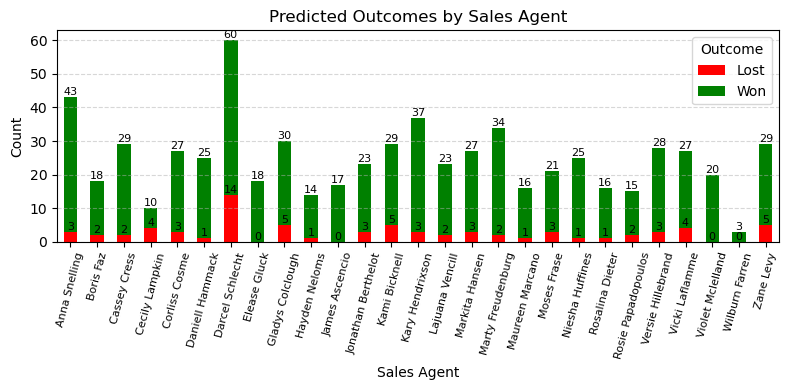

In [23]:
# Plotting
grouped.set_index('sales_agent', inplace=True)
ax = grouped.plot(kind='bar', figsize=(8, 4), stacked=True, color=['red', 'green'])

# Add labels and title
plt.title('Predicted Outcomes by Sales Agent', fontsize=12)
plt.xlabel('Sales Agent', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=75, fontsize=8)
plt.legend(title='Outcome', labels=['Lost', 'Won'], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show values on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

#### This information could be save for further analysis

In [ ]:
# Select relevant columns for export, including original (non-encoded) columns
export_columns = ["opportunity_id", "sales_agent", "product", "account", "Predicted_Outcome", "Win_Probability"]
results_to_export = prospecting_data[export_columns]

# Export results to a CSV file
output_file = "predicted_deals.csv"
results_to_export.to_csv(output_file, index=False)

print(f"Results successfully exported to {output_file}")